In [1]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib.lines import Line2D
import torch
import ot.plot
from IPython import display
import time
import seaborn as sns

In [2]:
import sys
sys.path.append('../../code/')
from generate_data import make_data,make_data_1d
from linear_solver import UOT_W
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
def plot2D_samples_mat2(xs, xt, G, thr=1e-8, **kwargs):

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scale = kwargs['alpha']
        del kwargs['alpha']
    else:
        scale = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j]/ mx, **kwargs)

In [5]:
bl="#4A90E2"
o='#F5A623'
v="#7ED321"

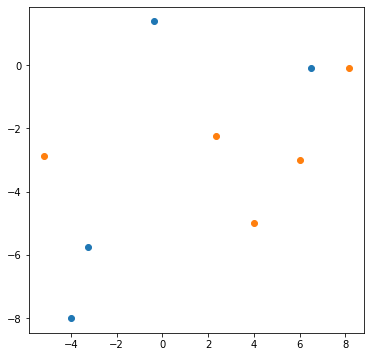

In [6]:
np.random.seed(1)
X=np.vstack((np.random.randn(1,2)+np.array([-2,2]),np.random.randn(1,2)+np.array([7,1]),np.random.randn(2,2)+np.array([-5,-5])))
Y=np.vstack((np.random.randn(3,2)+np.array([2,-2]),np.random.randn(1,2)+np.array([7,1]),np.random.randn(1,2)+np.array([-5,-2])))
#X,Y=make_data("iso_gaussians",8,2)

Y[1,:]=np.array([4,-5])
Y[2,:]=np.array([6,-3])
X[-2,:]=np.array([-4,-8])
n,d=X.shape

pl.figure(figsize=(6,6))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')

In [7]:
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox,OffsetImage

In [8]:
def mapData(dist_matrix, X, y, metric, title):
    mds = MDS(metric=metric, dissimilarity='precomputed', random_state=0)
    # Get the embeddings
    pts = mds.fit_transform(dist_matrix)
    # Plot the embedding, colored according to the class of the points
    fig = plt.figure(2, (15,6))
    ax = fig.add_subplot(1,2,1)    
    ax = sns.scatterplot(x=pts[:, 0], y=pts[:, 1],
                         hue=y, palette=['r', 'g', 'b', 'c'])

    # Add the second plot
    ax = fig.add_subplot(1,2,2)
    # Plot the points again
    plt.scatter(pts[:, 0], pts[:, 1])
    
    # Annotate each point by its corresponding face image
    for x, ind in zip(X, range(pts.shape[0])):
        im = x.reshape(64,64)
        imagebox = OffsetImage(im, zoom=0.3, cmap=plt.cm.gray)
        i = pts[ind, 0]
        j = pts[ind, 1]
        ab = AnnotationBbox(imagebox, (i, j), frameon=False)
        ax.add_artist(ab)
    plt.title(title)    
    plt.show()

In [9]:
mine=io.imread("./data/Images/mine.png")
factory=io.imread("./data/Images/factory.png")
warehouse1=io.imread("./data/Images/mix1.png")
warehouse2=io.imread("./data/Images/mix2.png")

In [10]:
C=ot.dist(X,Y)
Cx=ot.dist(X,X)
Cy=ot.dist(Y,Y)

n=X.shape[0]
m=Y.shape[0]
a,b=np.ones((n,)),np.ones((m,))

a[0]=3
b[-1]=2

In [11]:
P=ot.emd(a,b,C)
a_P=P@np.ones(m)
b_P=(P.T)@np.ones(n)

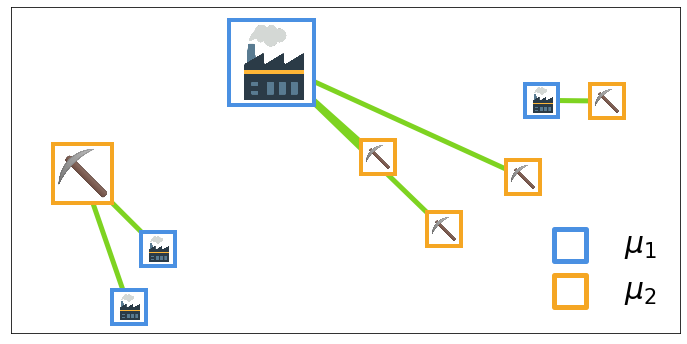

In [13]:
fig, ax = pl.subplots(figsize=(12,6))
z=.05
s=1e3
plot2D_samples_mat2(X,Y,P, c=v,linewidth=5)
for i in range(4):
    imagebox = OffsetImage(factory, zoom=a_P[i]*z)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, X[i,:],bboxprops=dict(edgecolor=bl,linewidth=4))
    ax.add_artist(ab)
for i in range(5):   
    imagebox = OffsetImage(mine, zoom=b_P[i]*z)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,Y[i,:],bboxprops=dict(edgecolor=o,linewidth=4))
    ax.add_artist(ab)

    
pl.scatter(X[:, 0], X[:, 1],marker="s", facecolors='none', edgecolors=bl,label="$\mu_1$",s=s,linewidth=5)
pl.scatter(Y[:, 0], Y[:, 1],marker="s", facecolors='none', edgecolors=o,label="$\mu_2$",s=s,linewidth=5)
# Fix the display limits to see everything
ax.set_xlim(-7, 10)
ax.set_ylim(-9,3.5)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])

#handles, labels = pl.gca().get_legend_handles_labels()
#handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.75, .4),prop={'size': 30})
pl.savefig("../../Figures/UOT/Factory_warehouse_OT.pdf",bbox_inches='tight')
pl.show()

In [14]:
Puot,Qx,Qy=UOT_W(a,b,C,lam=1,Cx=Cx,Cy=Cy,innerplan=True,solver="ECOS")

a_Puot=Puot@np.ones(m)
b_Puot=(Puot.T)@np.ones(n)

In [15]:
a_Puot,b_Puot

(array([3.00000000e+00, 1.00000000e+00, 4.30376637e-10, 2.00000000e+00]),
 array([3.00000000e+00, 1.60621001e-10, 2.43267893e-10, 1.00000000e+00,
        2.00000000e+00]))

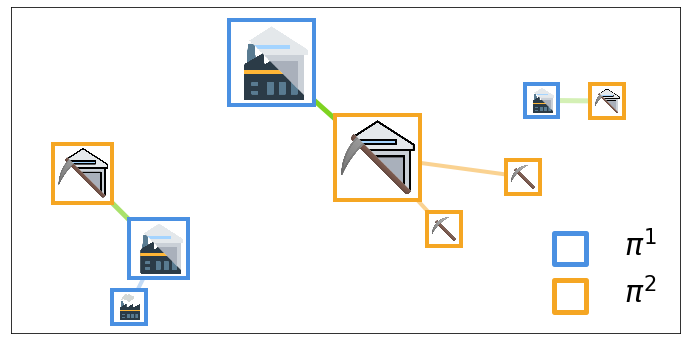

In [18]:
fig, ax = pl.subplots(figsize=(12,6))
z=.05
s=1e3
plot2D_samples_mat2(X,Y,Puot, c=v,linewidth=5)
plot2D_samples_mat2(X, X, Qx, c=bl,linewidth=4)
plot2D_samples_mat2(Y, Y, Qy, c=o,linewidth=4)
for i in range(4):
    if i ==2:# or i==1 or i==5:
        imagebox = OffsetImage(factory, zoom=a_P[i]*z)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, X[i,:],bboxprops=dict(edgecolor=bl,linewidth=4))
        ax.add_artist(ab)
    else:
        imagebox = OffsetImage(warehouse1, zoom=a_Puot[i]*z)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, X[i,:],bboxprops=dict(edgecolor=bl,linewidth=4))
        ax.add_artist(ab)
        
for i in range(5):
    if i ==1 or i==2:# or i==4:
        imagebox = OffsetImage(mine, zoom=b_P[i]*z)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, Y[i,:],bboxprops=dict(edgecolor=o,linewidth=4))
        ax.add_artist(ab)
    else:
        imagebox = OffsetImage(warehouse2, zoom=b_Puot[i]*z)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, Y[i,:],bboxprops=dict(edgecolor=o,linewidth=4))
        ax.add_artist(ab)



    
pl.scatter(X[:, 0], X[:, 1],marker="s", facecolors='none', edgecolors=bl,label="$\pi^1$",s=s,linewidth=5)
pl.scatter(Y[:, 0], Y[:, 1],marker="s", facecolors='none', edgecolors=o,label="$\pi^2$",s=s,linewidth=5)
# Fix the display limits to see everything
ax.set_xlim(-7, 10)
ax.set_ylim(-9,3.5)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])

pl.legend(frameon=False,bbox_to_anchor=(.75, .4),prop={'size': 30})
pl.savefig("../../Figures/UOT/Factory_warehouse_UOT.pdf",bbox_inches='tight')
pl.show()

In [20]:
lam=[.1,2,10]
P_l=[]
Qx_l=[]
Qy_l=[]
a_w_l=[]
b_w_l=[]
for l in lam:
    P,Qx,Qy=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,innerplan=True,solver="ECOS")
    P_l+=[P/P.max()]
    Qx_l+=[Qx]
    Qy_l+=[Qy]
    a_w_l+=[P@np.ones(n)]
    b_w_l+=[(P.T)@np.ones(n)]

In [21]:
Qy_l[0].max()

0.9999999995399941

In [22]:
P_l[0].max()

1.0

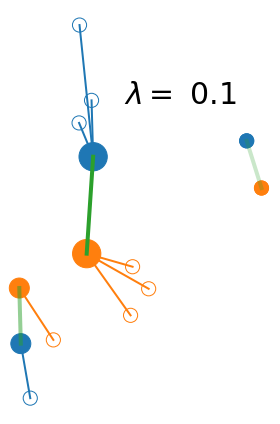

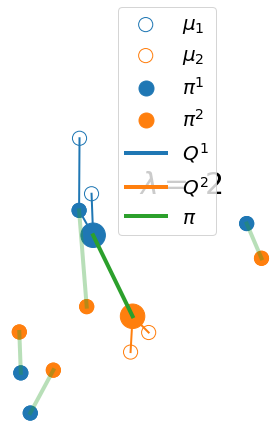

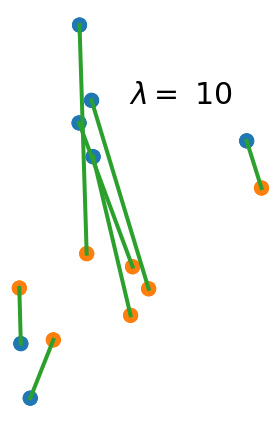

In [23]:
s=200
for i,l in enumerate(lam):
    pl.figure(figsize=(4,6))
    pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_w_l[i]*s)
    pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_w_l[i]*s)

    pl.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='C0',label="$\mu_1$",s=s)
    pl.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s)
    
    
    plot2D_samples_mat2(X, X, Qx_l[i], c='C0',linewidth=2)
    plot2D_samples_mat2(Y, Y, Qy_l[i], c='C1',linewidth=2)
    plot2D_samples_mat2(X, Y, P_l[i], c='C2',linewidth=4)
    if i==1:
        label1 = Line2D([0], [0], label="$\pi^1$", marker='o', color='C0', linestyle='',markersize=15)
        label2 = Line2D([0], [0], label="$\pi^2$", marker='o', color='C1', linestyle='',markersize=15)
        label3 = Line2D([0], [0], label="$Q^1$", color='C0', linestyle='solid',alpha=1,linewidth=4)
        label4 = Line2D([0], [0], label="$Q^2$", color='C1', linestyle='solid',alpha=1,linewidth=4)
        label5 = Line2D([0], [0], label="$\pi$", color='C2', linestyle='solid',linewidth=4)
        handles, labels = pl.gca().get_legend_handles_labels()
        handles.extend([label1,label2,label3,label4,label5])#,label6,label7])
        pl.legend(handles=handles,bbox_to_anchor=(.6,.6), prop={'size': 20})
    pl.axis('off')
    pl.tight_layout()
    if i==0:
        pl.title("$\lambda =$ %1.1f"%l,size=30,x=.65,y=.75)
    else:
        pl.title("$\lambda =$ %i"%l,size=30,x=.65,y=.75)
    #pl.savefig("./Figures/UOT/hierarchy"+str(i)+".pdf",bbox_inches='tight')

In [22]:
P,Qx,Qy=logsinkhorn(a.float(),b.float(),torch.tensor(C).float(),lam=1,eps=.5,numiter=500,pen="sinkhorn",
               Cx=torch.tensor(Cx).float(),Cy=torch.tensor(Cy).float(),numiter2=10,innerplan=True,eps2=.1)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

print(torch.sum(P))
print(torch.sum(P*C))

tensor(9.0000)
tensor(57.9502, dtype=torch.float64)


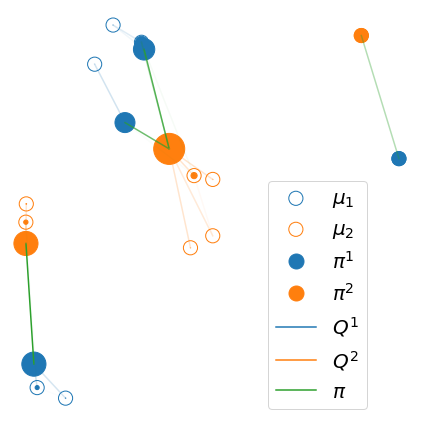

In [11]:
s=200
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy.numpy(), c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
#pl.scatter(X[:, 0], X[:, 1], c='C0',alpha=0.2)
#pl.scatter(Y[:, 0], Y[:, 1], c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='C0',label="$\mu_1$",s=s)
pl.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s)
label1 = Line2D([0], [0], label="$\pi^1$", marker='o', color='C0', linestyle='',markersize=15)
label2 = Line2D([0], [0], label="$\pi^2$", marker='o', color='C1', linestyle='',markersize=15)
label3 = Line2D([0], [0], label="$Q^1$", color='C0', linestyle='solid',alpha=1)
label4 = Line2D([0], [0], label="$Q^2$", color='C1', linestyle='solid',alpha=1)
label5 = Line2D([0], [0], label="$\pi$", color='C2', linestyle='solid')
#label6 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',alpha=0.2)
#label7 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',alpha=0.2)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4,label5])#,label6,label7])
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles,bbox_to_anchor=(.9,.6), prop={'size': 20})
#pl.savefig("../Figures/cluster_S1.pdf",bbox_inches='tight')

In [12]:
P,Qx,Qy=logsinkhorn(a.float(),b.float(),torch.tensor(C).float(),lam=1,eps=.5,numiter=500,pen="sinkhorn",
               Cx=torch.tensor(Cx).float(),Cy=torch.tensor(Cy).float(),numiter2=10,innerplan=True,eps2=1)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

print(torch.sum(P))
print(torch.sum(P*C))

tensor(9.0000)
tensor(64.0035, dtype=torch.float64)


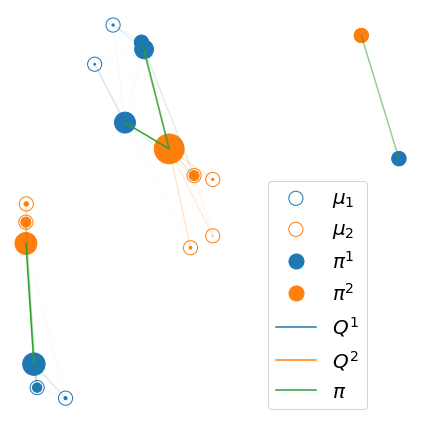

In [13]:
s=200
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy.numpy(), c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
#pl.scatter(X[:, 0], X[:, 1], c='C0',alpha=0.2)
#pl.scatter(Y[:, 0], Y[:, 1], c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='C0',label="$\mu_1$",s=s)
pl.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s)
label1 = Line2D([0], [0], label="$\pi^1$", marker='o', color='C0', linestyle='',markersize=15)
label2 = Line2D([0], [0], label="$\pi^2$", marker='o', color='C1', linestyle='',markersize=15)
label3 = Line2D([0], [0], label="$Q^1$", color='C0', linestyle='solid',alpha=1)
label4 = Line2D([0], [0], label="$Q^2$", color='C1', linestyle='solid',alpha=1)
label5 = Line2D([0], [0], label="$\pi$", color='C2', linestyle='solid')
#label6 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',alpha=0.2)
#label7 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',alpha=0.2)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4,label5])#,label6,label7])
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles,bbox_to_anchor=(.9,.6), prop={'size': 20})
#pl.savefig("../Figures/cluster_S2.pdf",bbox_inches='tight')

In [14]:
P,Qx,Qy=logsinkhorn(a.float(),b.float(),torch.tensor(C).float(),lam=1,eps=.5,numiter=500,pen="sinkhorn",
               Cx=torch.tensor(Cx).float(),Cy=torch.tensor(Cy).float(),numiter2=10,innerplan=True,eps2=10)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

print(torch.sum(P))
print(torch.sum(P*C))

tensor(9.)
tensor(111.8721, dtype=torch.float64)


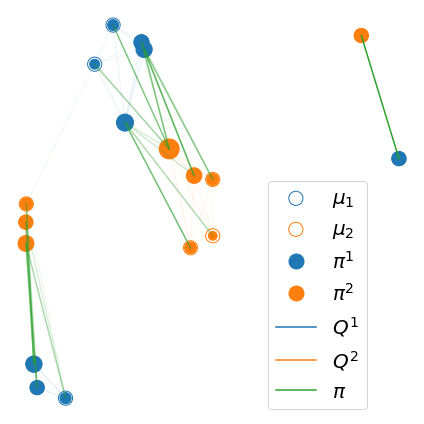

In [15]:
s=200
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy.numpy(), c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
#pl.scatter(X[:, 0], X[:, 1], c='C0',alpha=0.2)
#pl.scatter(Y[:, 0], Y[:, 1], c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='C0',label="$\mu_1$",s=s)
pl.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s)
label1 = Line2D([0], [0], label="$\pi^1$", marker='o', color='C0', linestyle='',markersize=15)
label2 = Line2D([0], [0], label="$\pi^2$", marker='o', color='C1', linestyle='',markersize=15)
label3 = Line2D([0], [0], label="$Q^1$", color='C0', linestyle='solid',alpha=1)
label4 = Line2D([0], [0], label="$Q^2$", color='C1', linestyle='solid',alpha=1)
label5 = Line2D([0], [0], label="$\pi$", color='C2', linestyle='solid')
#label6 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',alpha=0.2)
#label7 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',alpha=0.2)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4,label5])#,label6,label7])
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles,bbox_to_anchor=(.9,.6), prop={'size': 20})
#pl.savefig("../Figures/cluster_S3.pdf",bbox_inches='tight')

# Evolution Hierarchy

### Exemple 1

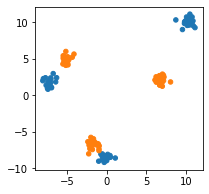

In [25]:
n,d=60,2
np.random.seed(0)
X,Y=make_data('mog_reg',n,d)
H=torch.zeros((60,2))
H[:20,:]=5*torch.ones((20,2))
H[20:40,:]=-2*torch.ones((20,2))
X+=H


C=ot.dist(X,Y)
Cx=ot.dist(X,X)
Cy=ot.dist(Y,Y)
a=torch.ones((n,))
b=torch.ones((n,))

s=2e1
pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=a*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=b*s)

In [26]:
lam=np.logspace(-2.5, 2.8, num=500)
#print(lam)
pi1_l=[]
pi2_l=[]

for l in lam:
    P,Qx,Qy=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,innerplan=True,solver="ECOS")
    pi1_l+=[np.sum(P,1)]
    pi2_l+=[np.sum(P,0)]

In [27]:
thr_l=[1e-6,1e-5,1e-4,1e-3]
repre1=np.zeros((len(lam),len(thr_l)))
repre2=np.zeros((len(lam),len(thr_l)))
for i,l in enumerate(lam):
    for j,thr in enumerate(thr_l):
        repre1[i,j]=sum(pi1_l[i]>thr)
        repre2[i,j]=sum(pi2_l[i]>thr)

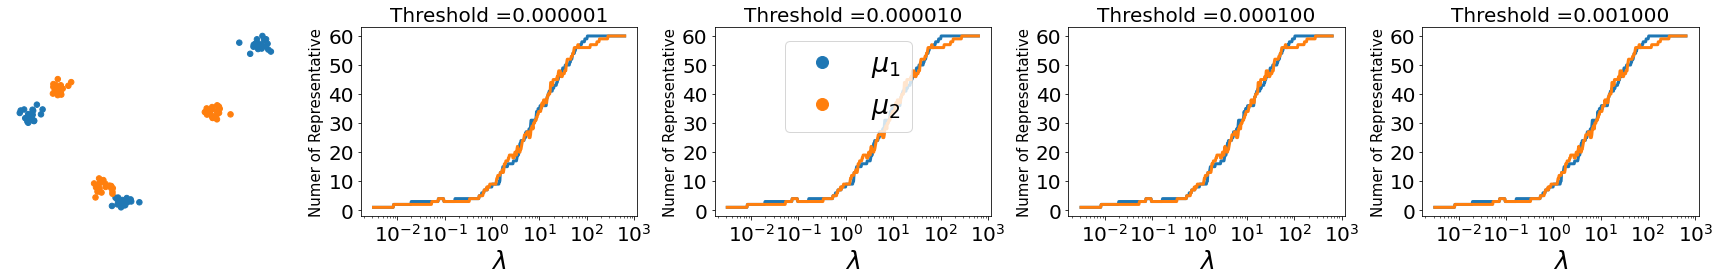

In [36]:
s=3e1
pl.figure(figsize=(24,4))
pl.subplot(1,len(thr_l)+1,1)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b*s)
pl.axis('off')
label1 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',markersize=12)
label2 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',markersize=12)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])
for j in range(len(thr_l)):
    pl.subplot(1,len(thr_l)+1,j+2)
    pl.plot(lam,repre1[:,j],c='C0',linewidth=3)
    pl.plot(lam,repre2[:,j],c='C1',linewidth=3)
    pl.xscale("log")
    pl.xlabel("$\lambda$",size=25)
    pl.ylabel("Numer of Representative",size=15)
    pl.xticks(fontsize = 20)
    pl.yticks(fontsize = 20)
    pl.title("Threshold =%1.6f"%thr_l[j],size=20) 
pl.tight_layout()
pl.legend(handles=handles,bbox_to_anchor=(-1.8,1), prop={'size': 27})
#pl.savefig("../Figures/nb_representative1.pdf",bbox_inches='tight')

### Exemple 2

100 100


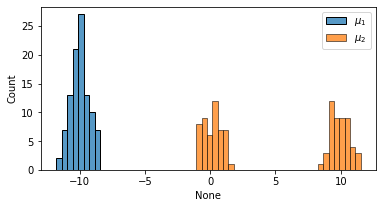

In [5]:
np.random.seed(0)
X,Y=make_data_1d("noise",50)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])
Cx=ot.dist(X[:,None],X[:,None])
Cy=ot.dist(Y[:,None],Y[:,None])

kde=False
pl.figure(figsize=(6,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",weights=a,binwidth=.4,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",weights=b,binwidth=.4,kde_kws=dict(bw_adjust=.5),stat="count")
pl.legend()

In [6]:
lam=np.logspace(-1.2,2.8, num=500)
#print(lam)
pi1_l=[]
pi2_l=[]

for l in lam:
    P,Qx,Qy=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,innerplan=True,solver="CLARABEL")
    pi1_l+=[np.sum(P,1)]
    pi2_l+=[np.sum(P,0)]

In [7]:
thr_l=[1e-5,1e-4,1e-3,1e-2]
repre1=np.zeros((len(lam),len(thr_l)))
repre2=np.zeros((len(lam),len(thr_l)))
for i,l in enumerate(lam):
    for j,thr in enumerate(thr_l):
        repre1[i,j]=sum(pi1_l[i]>thr)
        repre2[i,j]=sum(pi2_l[i]>thr)

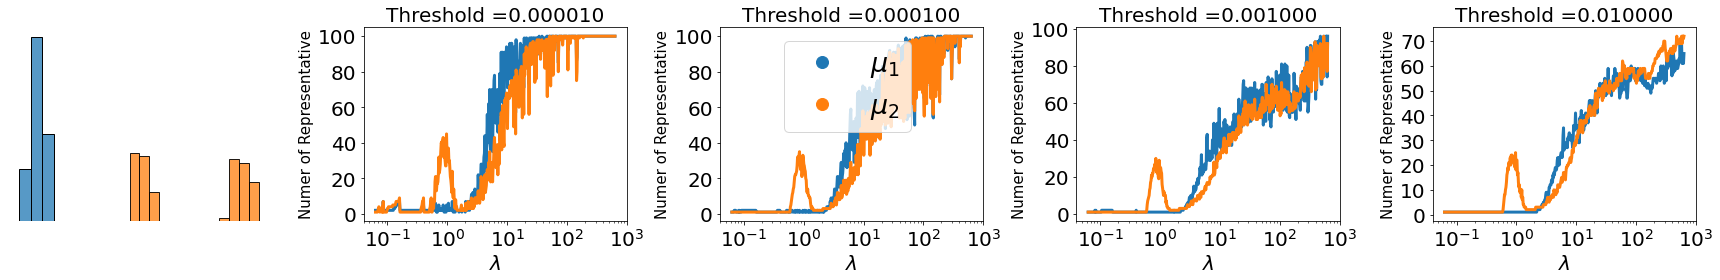

In [8]:
pl.figure(figsize=(24,4))
pl.subplot(1,len(thr_l)+1,1)
sns.histplot(x=X, kde=kde,weights=a,binwidth=1,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,weights=b,binwidth=1,kde_kws=dict(bw_adjust=.5),stat="count")
pl.axis('off')
label1 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',markersize=12)
label2 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',markersize=12)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])
for j in range(len(thr_l)):
    pl.subplot(1,len(thr_l)+1,j+2)
    pl.plot(lam,repre1[:,j],c='C0',linewidth=3)
    pl.plot(lam,repre2[:,j],c='C1',linewidth=3)
    pl.xscale("log")
    pl.xlabel("$\lambda$",size=20)
    pl.ylabel("Numer of Representative",size=15)
    pl.xticks(fontsize = 20)
    pl.yticks(fontsize = 20)
    pl.title("Threshold =%1.6f"%thr_l[j],size=20)
pl.tight_layout()
pl.legend(handles=handles,bbox_to_anchor=(-1.93,1), prop={'size': 27})
pl.savefig("../Figures/nb_representative2.pdf",bbox_inches='tight')